In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

/Users/dimazest/miniconda3/envs/notebook/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/dimazest/miniconda3/envs/notebook/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import matplotlib
matplotlib.rc('pdf', fonttype=42)

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import tools as t

/Users/dimazest/miniconda3/envs/notebook/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [4]:
!scp frank:/import/dima-scratch/phd-buildout/experiments/emnlp14/results_all.csv .

results_all.csv                               100%   24MB   4.8MB/s   00:05    


In [5]:
results = t.read_results()

# Max selection

/Users/dimazest/miniconda3/envs/notebook/lib/python3.5/site-packages/seaborn/categorical.py:1462: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level
/Users/dimazest/miniconda3/envs/notebook/lib/python3.5/site-packages/seaborn/categorical.py:1464: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future
  stat_data = remove_na(group_data[hue_mask])


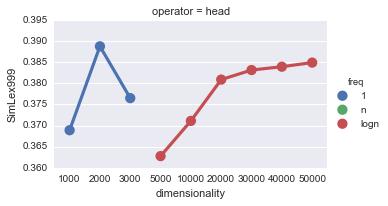

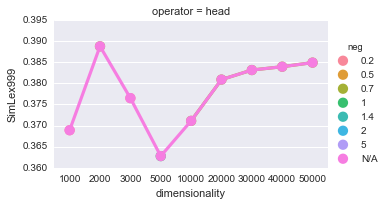

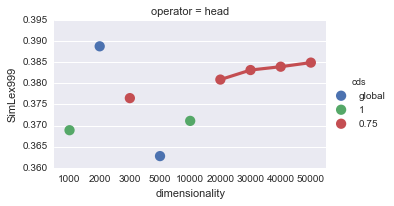

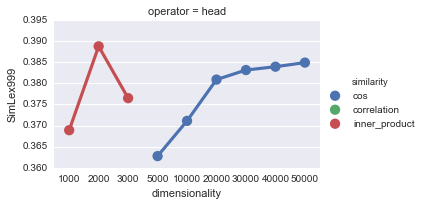

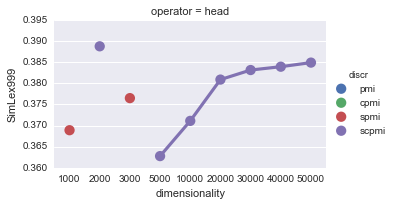

In [6]:
max_selection_simlex = t.plot_selection(
    results[results.index.get_level_values('operator') == 'head'],
    dataset='SimLex999',
    selector_function=t.max_('men'),
)

/Users/dimazest/miniconda3/envs/notebook/lib/python3.5/site-packages/seaborn/categorical.py:1462: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level
/Users/dimazest/miniconda3/envs/notebook/lib/python3.5/site-packages/seaborn/categorical.py:1464: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future
  stat_data = remove_na(group_data[hue_mask])


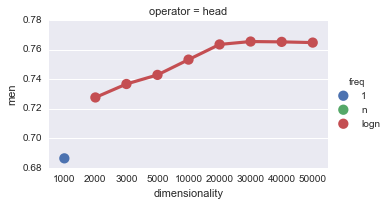

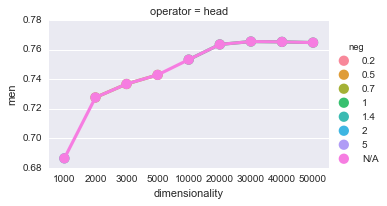

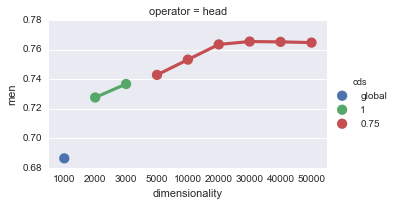

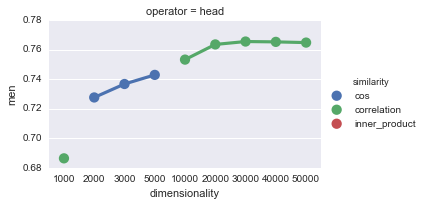

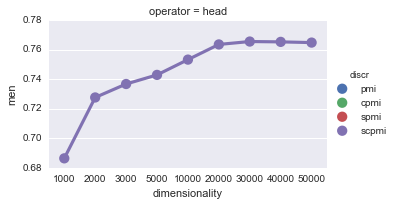

In [7]:
max_selection_men = t.plot_selection(
    results[results.index.get_level_values('operator') == 'head'],
    dataset='men',
    selector_function=t.max_('SimLex999'),
)

# Cross-validation

/Users/dimazest/miniconda3/envs/notebook/lib/python3.5/site-packages/seaborn/categorical.py:1462: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level
/Users/dimazest/miniconda3/envs/notebook/lib/python3.5/site-packages/seaborn/categorical.py:1464: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future
  stat_data = remove_na(group_data[hue_mask])


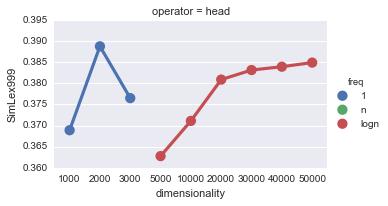

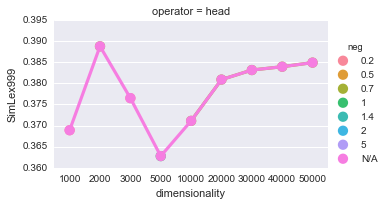

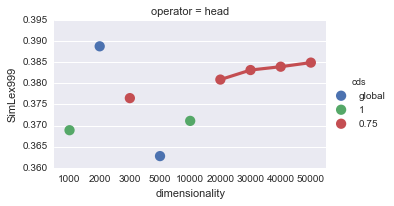

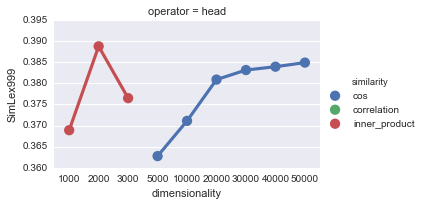

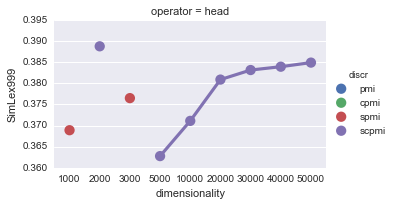

In [8]:
cross_validation_selection_simlex = t.plot_selection(
    results[results.index.get_level_values('operator') == 'head'],
    dataset='SimLex999',
    selector_function=t.cross_validation('men'),
)

/Users/dimazest/miniconda3/envs/notebook/lib/python3.5/site-packages/seaborn/categorical.py:1462: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level
/Users/dimazest/miniconda3/envs/notebook/lib/python3.5/site-packages/seaborn/categorical.py:1464: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future
  stat_data = remove_na(group_data[hue_mask])


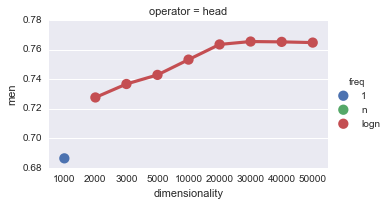

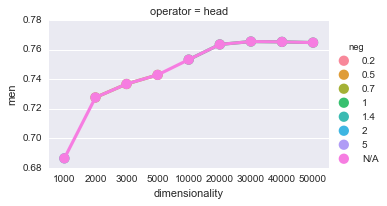

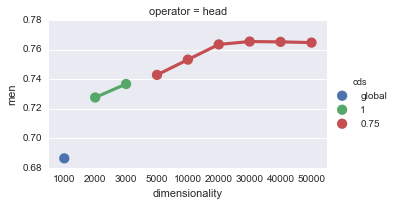

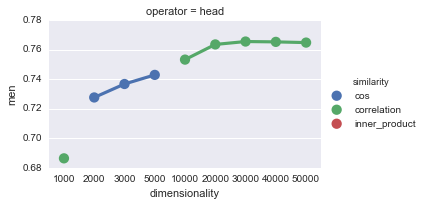

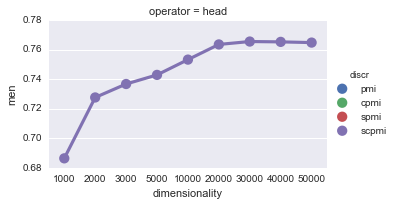

In [9]:
cross_validation_selection_men = t.plot_selection(
    results[results.index.get_level_values('operator') == 'head'],
    dataset='men',
    selector_function=t.cross_validation('SimLex999'),
)

# Heuristics

## SimLex-999

In [10]:
parameters = [
    'dimensionality', 'discr', 'cds', 'freq', 'neg', 'similarity',
]

In [11]:
t.anova(
    response='SimLex999',
    predictors=parameters,
    data=results,
).rsquared_adj

0.86701695238077925

In [12]:
feature_ablation_simlex = t.calculate_feature_ablation(
    responses=(
        'SimLex999',
        # 'men',
    ),
    predictors=parameters,
    data=results,
)

# feature_ablation.plot(kind='barh')#.get_figure().savefig('figures/emnlp2013_turk-parameter-ablation.pdf')
feature_ablation_simlex.sort_values(('partial R2', 'SimLex999'), ascending=False, inplace=True)

feature_ablation_simlex.round(3)

,partial R2
response,SimLex999
predictor,
similarity,0.379
freq,0.268
neg,0.241
dimensionality,0.083
discr,0.077
cds,0.064


In [13]:
_ = feature_ablation_simlex.copy()
_.columns.names = ['', '']
(
    _['partial R2']
    .round(3)
    .to_latex('figures/SimLex999-ablation.tex')
)

In [14]:
heuristics_selection_collection_simlex = {}

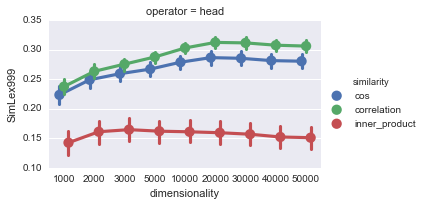

In [15]:
f = t.plot_interaction(results['max'], feature_ablation_simlex.index[0], 'SimLex999')

In [16]:
assert feature_ablation_simlex.index[0] == 'similarity'
r = results['max'].reset_index()

heuristics_selection_collection_simlex[0] = r.loc[
    r['similarity'] == 'correlation'
]

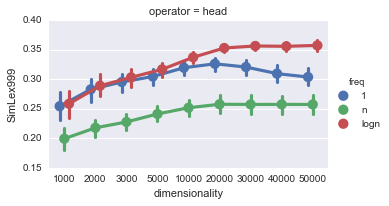

In [17]:
t.plot_interaction(heuristics_selection_collection_simlex[0], feature_ablation_simlex.index[1], 'SimLex999')

In [18]:
assert feature_ablation_simlex.index[1] == 'freq'

r = heuristics_selection_collection_simlex[0]

heuristics_selection_collection_simlex[1] =  r.loc[
    r['freq'] == 'logn'
]

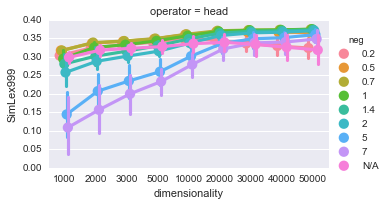

In [19]:
t.plot_interaction(heuristics_selection_collection_simlex[1], feature_ablation_simlex.index[2], 'SimLex999')

In [20]:
assert feature_ablation_simlex.index[2] == 'neg'

r = heuristics_selection_collection_simlex[1]

heuristics_selection_collection_simlex[2] =  r.loc[
    (r['neg'] == 0.7)
]

In [21]:
# Skip dimensionality
assert feature_ablation_simlex.index[3] == 'dimensionality'

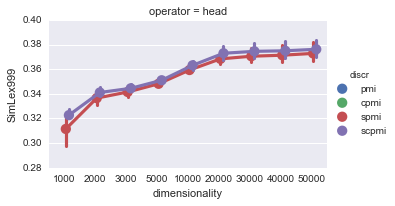

In [22]:
t.plot_interaction(heuristics_selection_collection_simlex[2], feature_ablation_simlex.index[4], 'SimLex999')

In [23]:
assert feature_ablation_simlex.index[4] == 'discr'

r = heuristics_selection_collection_simlex[2]

heuristics_selection_collection_simlex[3] =  r.loc[
    (r['discr'] == 'scpmi')
]

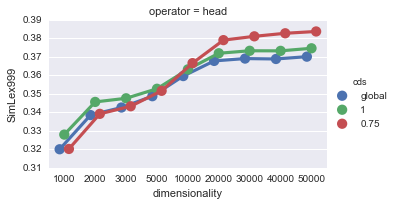

In [24]:
t.plot_interaction(heuristics_selection_collection_simlex[3], feature_ablation_simlex.index[5], 'SimLex999')

In [25]:
assert feature_ablation_simlex.index[5] == 'cds'

r = heuristics_selection_collection_simlex[3]

heuristics_selection_collection_simlex[4] =  r.loc[
    # *skip tuning for 50K
    (~(r['dimensionality'] < 10000) | ((r['cds'] == '1'))) &
    (~(r['dimensionality'] >= 10000) | ((r['cds'] == '0.75'))) &
    True
]

In [26]:
assert len(feature_ablation_simlex) == 6

In [27]:
heuristics_selection_simlex = heuristics_selection_collection_simlex[4].set_index(['operator', 'dimensionality'], drop=False)
heuristics_selection_simlex['selection'] = 'heuristics'

## MEN

In [28]:
t.anova(
    response='men',
    predictors=parameters,
    data=results,
).rsquared_adj

0.73306515868630373

In [29]:
feature_ablation_men = t.calculate_feature_ablation(
    responses=(
        'men',
    ),
    predictors=parameters,
    data=results,
)

# feature_ablation.plot(kind='barh')#.get_figure().savefig('figures/emnlp2013_turk-parameter-ablation.pdf')
feature_ablation_men.sort_values(('partial R2', 'men'), ascending=False, inplace=True)

feature_ablation_men.round(3)

,partial R2
response,men
predictor,
neg,0.309
freq,0.204
similarity,0.183
discr,0.119
dimensionality,0.108
cds,0.086


In [30]:
_ = feature_ablation_men.copy()
_.columns.names = ['', '']
(
    _['partial R2']
    .round(3)
    .to_latex('figures/men-ablation.tex')
)

In [31]:
heuristics_selection_collection_men = {}

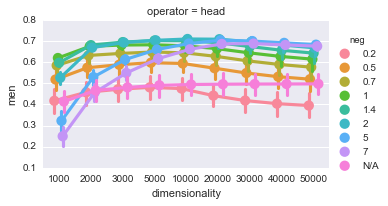

In [32]:
t.plot_interaction(results['max'], feature_ablation_men.index[0], 'men')

In [33]:
assert feature_ablation_men.index[0] == 'neg'

r = results['max'].reset_index()

heuristics_selection_collection_men[0] =  r.loc[
    # *coarse selection
    (~(r['dimensionality'] < 20000) | ((r['neg'] == 2) | (r['neg'] == 'N/A'))) &
    (~(r['dimensionality'] >= 20000) | ((r['neg'] == 5) | (r['neg'] == 'N/A'))) &
    True
]

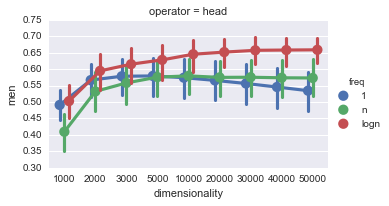

In [34]:
t.plot_interaction(heuristics_selection_collection_men[0], feature_ablation_men.index[1], 'men')

In [35]:
assert feature_ablation_men.index[1] == 'freq'

r = heuristics_selection_collection_men[0]

heuristics_selection_collection_men[1] =  r.loc[
    (r['freq'] == 'logn')
]

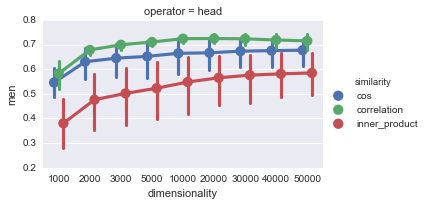

In [36]:
t.plot_interaction(heuristics_selection_collection_men[1], feature_ablation_men.index[2], 'men')

In [37]:
assert feature_ablation_men.index[2] == 'similarity'

r = heuristics_selection_collection_men[1]

heuristics_selection_collection_men[2] =  r.loc[
    (r['similarity'] == 'correlation')
]

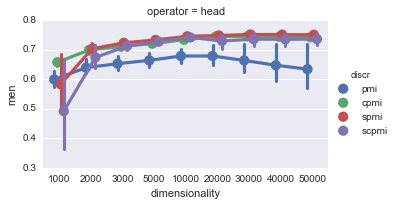

In [38]:
t.plot_interaction(heuristics_selection_collection_men[2], feature_ablation_men.index[3], 'men')

In [39]:
assert feature_ablation_men.index[3] == 'discr'

r = heuristics_selection_collection_men[2]

heuristics_selection_collection_men[3] =  r.loc[
    (r['discr'] == 'spmi')
]

In [40]:
# Skip dimensionality
assert feature_ablation_men.index[4] == 'dimensionality'

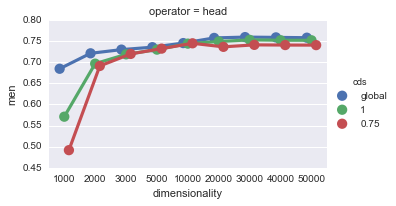

In [41]:
t.plot_interaction(heuristics_selection_collection_men[3], feature_ablation_men.index[5], 'men')

In [42]:
assert feature_ablation_men.index[5] == 'cds'

r = heuristics_selection_collection_men[3]

heuristics_selection_collection_men[4] =  r.loc[
    (r['cds'] == 'global')
]

In [43]:
assert len(feature_ablation_men) == 6

In [44]:
heuristics_selection_men = heuristics_selection_collection_men[4].set_index(['operator', 'dimensionality'], drop=False)
heuristics_selection_men['selection'] = 'heuristics'

#  Parameter selection comparison

In [45]:
'{:.3f}'.format(
    t.average_error(
        max_selection_simlex,
        heuristics_selection_simlex,
        'SimLex999',
    ),
)

'0.039'

In [46]:
'{:.3f}'.format(
    t.average_error(
        max_selection_men,
        heuristics_selection_men,
        'men',
    ),
)

'0.008'

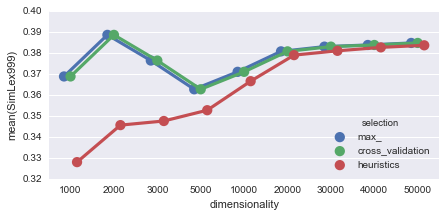

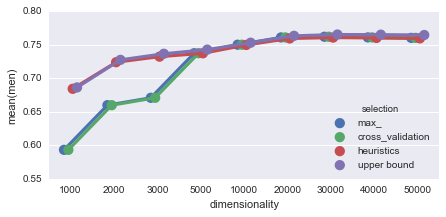

In [47]:
f, ax = plt.subplots(figsize=(7, 3))
t.plot_parameter_selection_comparison(
    [
        max_selection_simlex,
        cross_validation_selection_simlex,
        heuristics_selection_simlex,
    ],
    'SimLex999',
    ax=ax,
)
f.savefig('figures/SimLex999-results.pdf')

f, ax = plt.subplots(figsize=(7, 3))
t.plot_parameter_selection_comparison(
    [
        max_selection_simlex,
        cross_validation_selection_simlex,
        heuristics_selection_simlex,

        max_selection_men.assign(selection='upper bound')
    ],
    'SimLex999',
    'men',
    ax=ax,
)
f.savefig('figures/SimLex999-transfer.pdf')

In [48]:
max_selection_simlex.sort_index().round({'SimLex999': 3}).loc['head'].to_latex(
    'figures/SimLex999-max_-selection.tex',
    columns=[
        'SimLex999',
        'freq',
        'discr',
        'cds',
        'neg',
        'similarity',
    ],
)

In [49]:
heuristics_selection_simlex.sort_index().round({'SimLex999': 3}).loc['head'].to_latex(
    'figures/SimLex999-heuristics-selection.tex',
    columns=[
        'SimLex999',
        'freq',
        'discr',
        'cds',
        'neg',
        'similarity',
    ],
)

#### MEN

In [50]:
max_selection_men.sort_index().round({'men': 3}).loc['head'].to_latex(
    'figures/men-max_-selection.tex',
    columns=[
        'men',
        'freq',
        'discr',
        'cds',
        'neg',
        'similarity',
    ],
)

In [51]:
heuristics_selection_men.sort_index().round({'men': 3}).loc['head'].to_latex(
    'figures/men-heuristics-selection.tex',
    columns=[
        'men',
        'freq',
        'discr',
        'cds',
        'neg',
        'similarity',
    ],
)

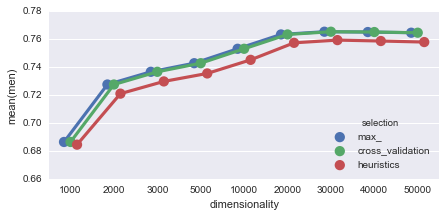

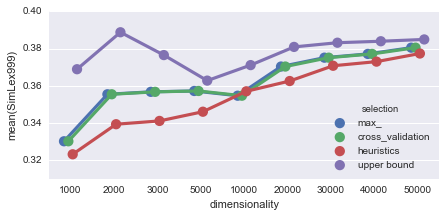

In [52]:
f, ax = plt.subplots(figsize=(7, 3))
t.plot_parameter_selection_comparison(
    [
        max_selection_men,
        cross_validation_selection_men,
        heuristics_selection_men,
    ],
    'men',
    ax=ax,
)
f.savefig('figures/men-results.pdf')

f, ax = plt.subplots(figsize=(7, 3))
t.plot_parameter_selection_comparison(
    [
        max_selection_men,
        cross_validation_selection_men,
        heuristics_selection_men,

        max_selection_simlex.assign(selection='upper bound')
    ],
    'men',
    'SimLex999',
    ax=ax,
)
f.savefig('figures/men-transfer.pdf')

In [53]:
'SimLex-999 to MEN (heuristics): {:.3f}'.format(
    t.average_error(
        max_selection_men,
        heuristics_selection_simlex,
        'men',
    ),
)

'SimLex-999 to MEN (heuristics): 0.006'

In [54]:
'SimLex-999 to MEN (max): {:.3f}'.format(
    t.average_error(
        max_selection_men,
        max_selection_simlex,
        'men',
    ),
)

'SimLex-999 to MEN (max): 0.039'

In [55]:
'MEN to SimLex999 (heuristics): {:.3f}'.format(
    t.average_error(
        max_selection_simlex,
        heuristics_selection_men,
        'SimLex999',
    ),
)

'MEN to SimLex999 (heuristics): 0.062'

In [56]:
'MEN to SimLex999 (heuristics): {:.3f}'.format(
    t.average_error(
        max_selection_simlex,
        max_selection_men,
        'SimLex999',
    ),
)

'MEN to SimLex999 (heuristics): 0.042'

## Union

In [57]:
results['max', 'lexical'] = (
    (
        (results['max', 'SimLex999'] / results['max', 'SimLex999'].max()) +
        (results['max', 'men'] / results['max', 'men'].max())
    ) / 2
)

In [58]:
max_selection_lexical = t.plot_selection(
    results[results.index.get_level_values('operator') == 'head'],
    dataset='lexical',
    selector_function=t.max_('SimLex999', 'men'),
    plot=False,
)

#### Heuristics

In [61]:
'{:.3f}'.format(
        t.anova(
        response='lexical',
        predictors=parameters,
        data=results,
    ).rsquared_adj
)

'0.817'

In [63]:
feature_ablation_lexical = t.calculate_feature_ablation(
    responses=(
        'lexical',
    ),
    predictors=parameters,
    data=results,
)

feature_ablation_lexical.sort_values(('partial R2', 'lexical'), ascending=False, inplace=True)

feature_ablation_lexical.round(3)

,partial R2
response,lexical
predictor,
similarity,0.299
neg,0.280
freq,0.231
dimensionality,0.095
discr,0.095
cds,0.076


In [64]:
_ = feature_ablation_lexical.copy()
_.columns.names = ['', '']
(
    _['partial R2']
    .round(3)
    .to_latex('figures/lexical-ablation.tex')
)

In [65]:
heuristics_selection_collection_lexical = {}

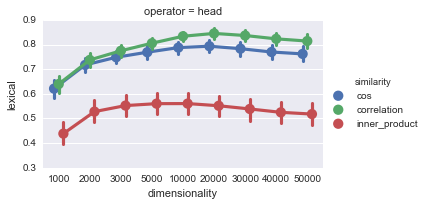

In [66]:
t.plot_interaction(results['max'], feature_ablation_lexical.index[0], 'lexical')

In [67]:
assert feature_ablation_lexical.index[0] == 'similarity'

r = results['max'].reset_index()

heuristics_selection_collection_lexical[0] = r.loc[
    r['similarity'] == 'correlation'
]

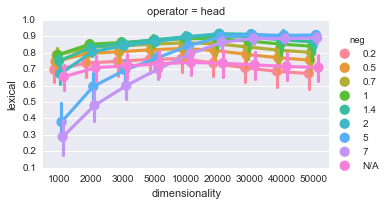

In [68]:
t.plot_interaction(heuristics_selection_collection_lexical[0], feature_ablation_lexical.index[1], 'lexical')

In [69]:
assert feature_ablation_lexical.index[1] == 'neg'

r = heuristics_selection_collection_lexical[0]

heuristics_selection_collection_lexical[1] =  r.loc[
    (~(r['dimensionality'] < 20000) | (r['neg'] == 1)) &
    (~(r['dimensionality'] >= 20000) | (r['neg'] == 2)) &

    True
]

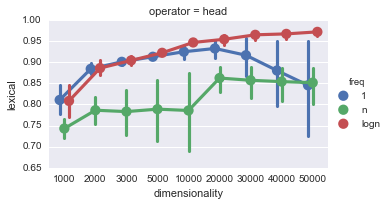

In [70]:
t.plot_interaction(heuristics_selection_collection_lexical[1], feature_ablation_lexical.index[2], 'lexical')

In [71]:
assert feature_ablation_lexical.index[2] == 'freq'

r = heuristics_selection_collection_lexical[1]

heuristics_selection_collection_lexical[2] =  r.loc[
    r['freq'] == 'logn'
]

In [72]:
assert feature_ablation_lexical.index[3] == 'dimensionality'

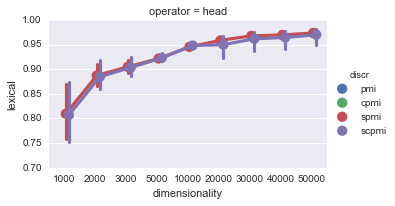

In [73]:
t.plot_interaction(heuristics_selection_collection_lexical[2], feature_ablation_lexical.index[4], 'lexical')

In [79]:
assert feature_ablation_lexical.index[4] == 'discr'

r = heuristics_selection_collection_lexical[2]

heuristics_selection_collection_lexical[3] =  r.loc[
    r['discr'] == 'scpmi'
]

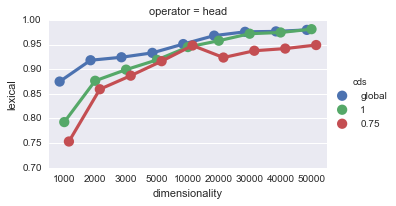

In [80]:
t.plot_interaction(heuristics_selection_collection_lexical[3], feature_ablation_lexical.index[5], 'lexical')

In [81]:
assert feature_ablation_lexical.index[5] == 'cds'

r = heuristics_selection_collection_lexical[3]

heuristics_selection_collection_lexical[4] =  r.loc[
    r['cds'] == 'global'
]

In [82]:
assert len(feature_ablation_lexical) == 6

In [83]:
heuristics_selection_lexical = heuristics_selection_collection_lexical[4].set_index(['operator', 'dimensionality'], drop=False)
heuristics_selection_lexical['selection'] = 'heuristics'

In [84]:
max_selection_lexical.sort_index().round(
    {
        'men': 3,
        'SimLex999': 3,
        'lexical': 3,
    }
).loc['head'].to_latex(
    'figures/lexical-max-selection.tex',
    columns=[
        'SimLex999',
        'men',
        'lexical',
        'freq',
        'discr',
        'cds',
        'neg',
        'similarity',
    ],
)

In [85]:
heuristics_selection_lexical.sort_index().round(
    {
        'men': 3,
        'SimLex999': 3,
        'lexical': 3,
    }
).loc['head'].to_latex(
    'figures/lexical-heuristics-selection.tex',
    columns=[
        'SimLex999',
        'men',
        'lexical',
        'freq',
        'discr',
        'cds',
        'neg',
        'similarity',
    ],
)

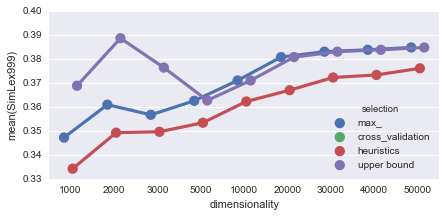

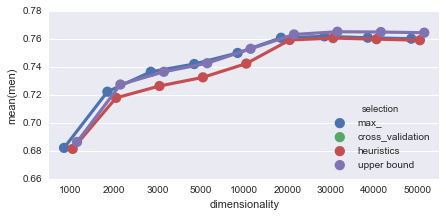

In [86]:
f, ax = plt.subplots(figsize=(7, 3))
t.plot_parameter_selection_comparison(
    [
        max_selection_lexical,
        heuristics_selection_lexical,
        
        max_selection_simlex.assign(selection='upper bound')
    ],
    'SimLex999',
    'SimLex999',
    ax=ax,
)
f.savefig('figures/lexical-results-SimLex999.pdf')

f, ax = plt.subplots(figsize=(7, 3))
t.plot_parameter_selection_comparison(
    [
        max_selection_lexical,
        heuristics_selection_lexical,

        max_selection_men.assign(selection='upper bound'),
    ],
    'men',
    'men',
    ax=ax,
)
f.savefig('figures/lexical-results-men.pdf')

In [87]:
'Lexical on SimLex999 (max): {:.3f}'.format(
    t.average_error(
        max_selection_simlex,
        max_selection_lexical,
        'SimLex999',
    ),
)

'Lexical on SimLex999 (max): 0.020'

In [88]:
'Lexical on men (max): {:.3f}'.format(
    t.average_error(
        max_selection_men,
        max_selection_lexical,
        'men',
    ),
)

'Lexical on men (max): 0.004'

In [89]:
'Lexical on SimLex999 (heuristics): {:.3f}'.format(
    t.average_error(
        max_selection_simlex,
        heuristics_selection_lexical,
        'SimLex999',
    ),
)

'Lexical on SimLex999 (heuristics): 0.048'

In [90]:
'Lexical on men (heuristics): {:.3f}'.format(
    t.average_error(
        max_selection_men,
        heuristics_selection_lexical,
        'men',
    ),
)

'Lexical on men (heuristics): 0.010'

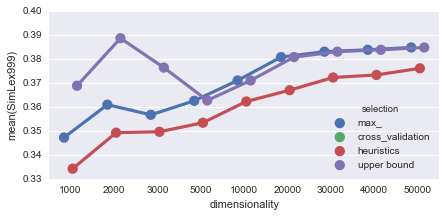

In [91]:
f, ax = plt.subplots(figsize=(7, 3))
t.plot_parameter_selection_comparison(
    [
        max_selection_lexical,
        heuristics_selection_lexical,

        max_selection_simlex.assign(selection='upper bound')
    ],
    'lexical',
    'SimLex999',
    ax=ax,
)
# f.savefig('figures/SimLex999-transfer.pdf')

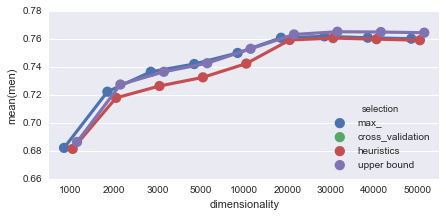

In [92]:
f, ax = plt.subplots(figsize=(7, 3))
t.plot_parameter_selection_comparison(
    [
        max_selection_lexical,
        heuristics_selection_lexical,

        max_selection_men.assign(selection='upper bound')
    ],
    'lexical',
    'men',
    ax=ax,
)
# f.savefig('figures/SimLex999-transfer.pdf')

# Compositional

## Max

In [95]:
# results.head()

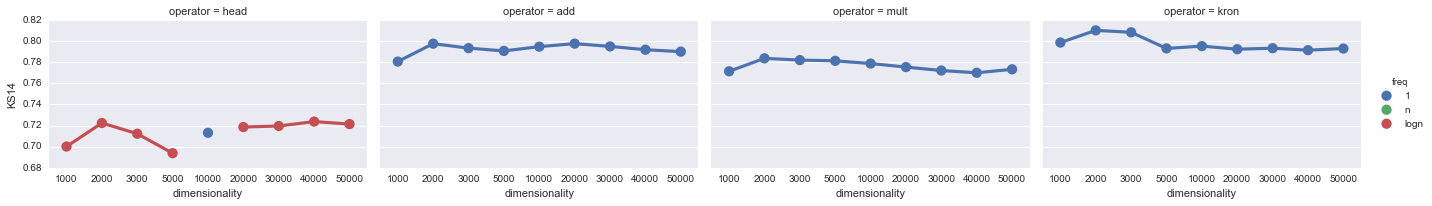

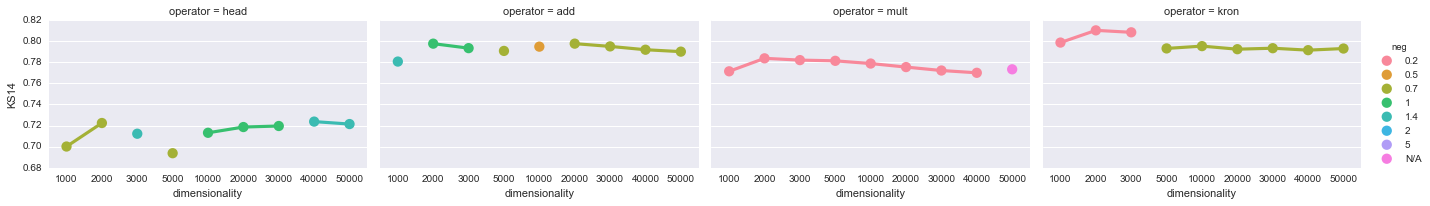

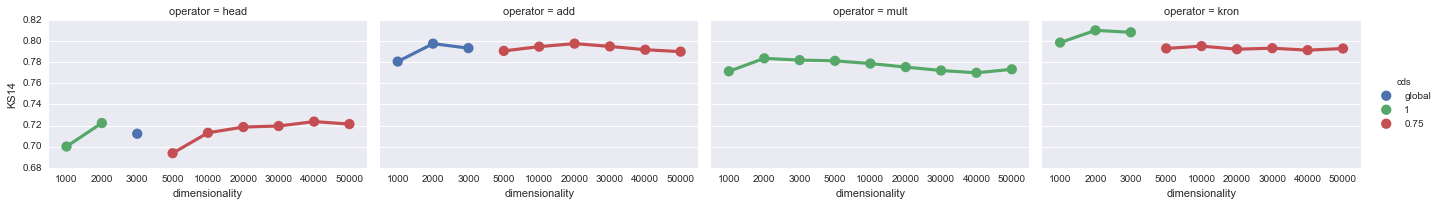

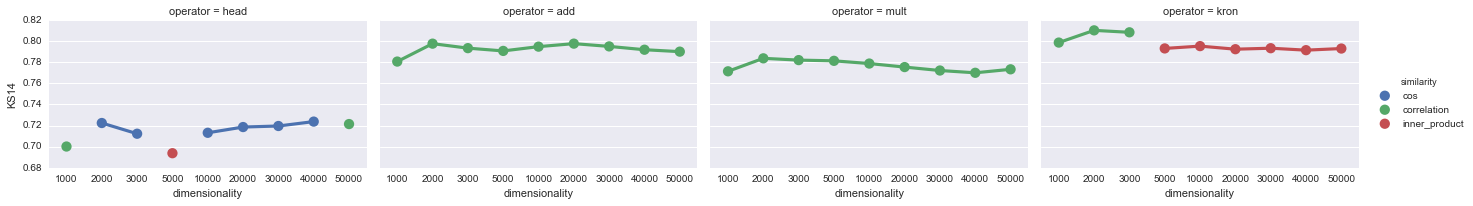

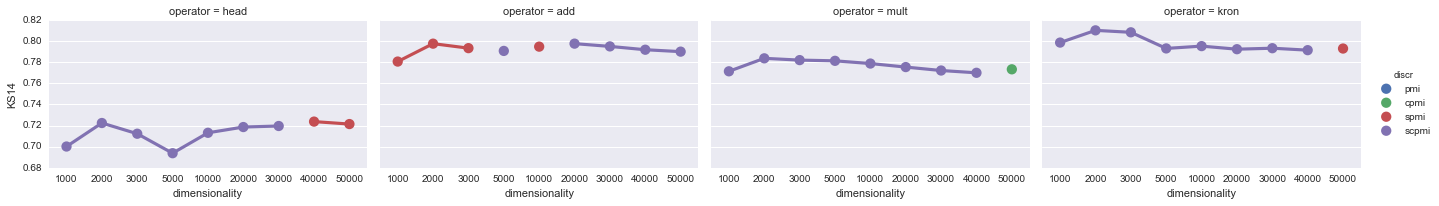

In [107]:
max_selection_ks14 = t.plot_selection(
    results[results['max', 'KS14'].notnull()],
    dataset='KS14',
    selector_function=t.max_('GS11'),
)

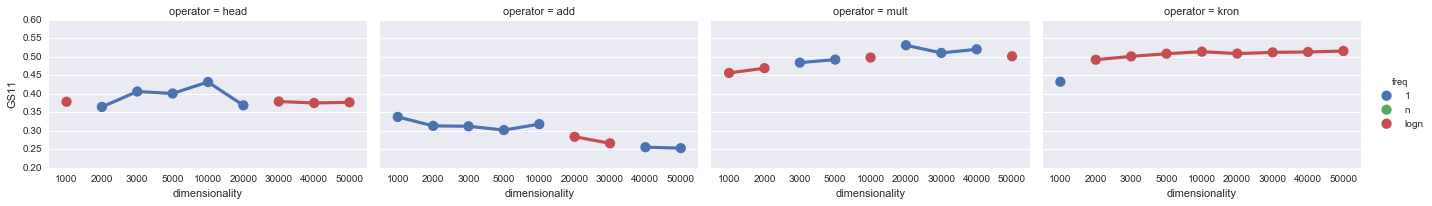

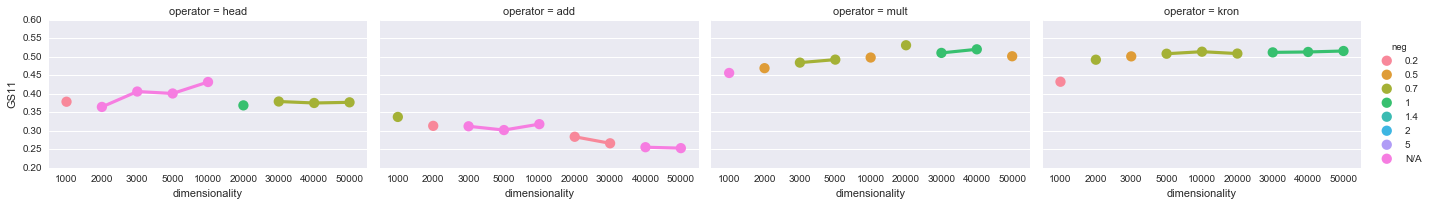

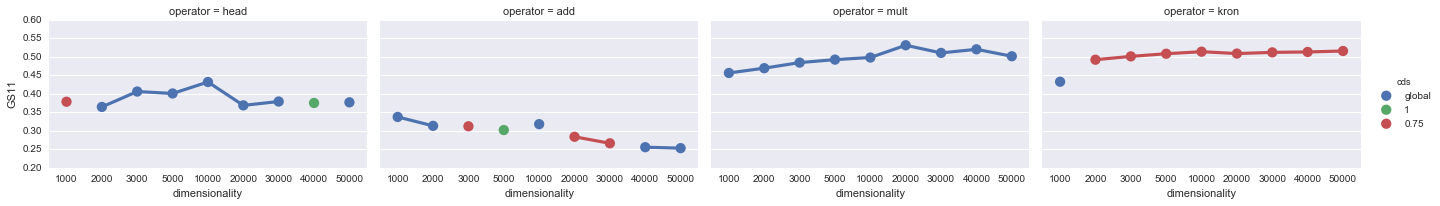

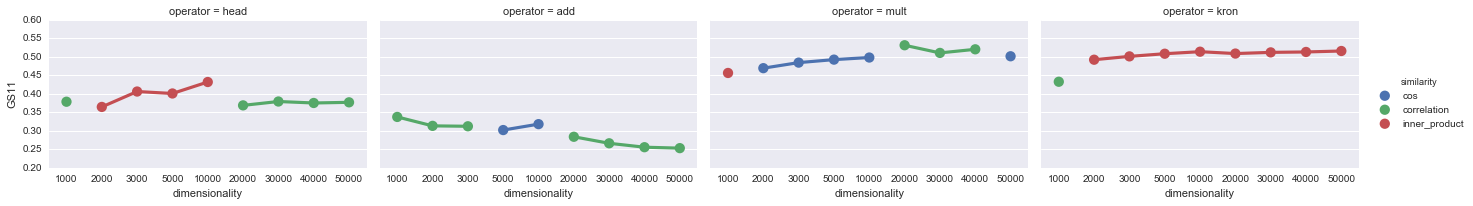

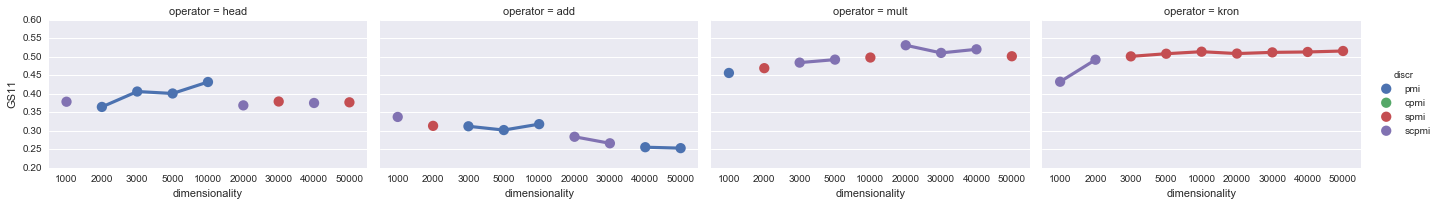

In [109]:
max_selection_gs11 = t.plot_selection(
    results[results['max', 'GS11'].notnull()],
    dataset='GS11',
    selector_function=t.max_('KS14'),
)

In [ ]:
# max_selection_phraserel = t.plot_selection(
#     results[results['max', 'PhraseRel'].notnull()],
#     dataset='PhraseRel',
#     selector_function=t.max_('KS14', 'GS11'),
# )

## Cross-validation

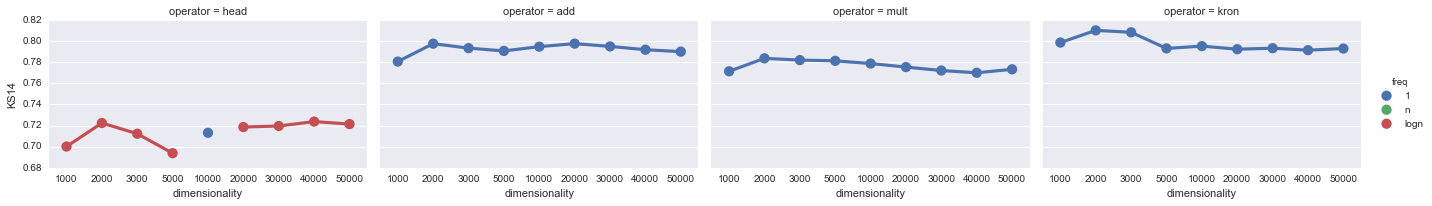

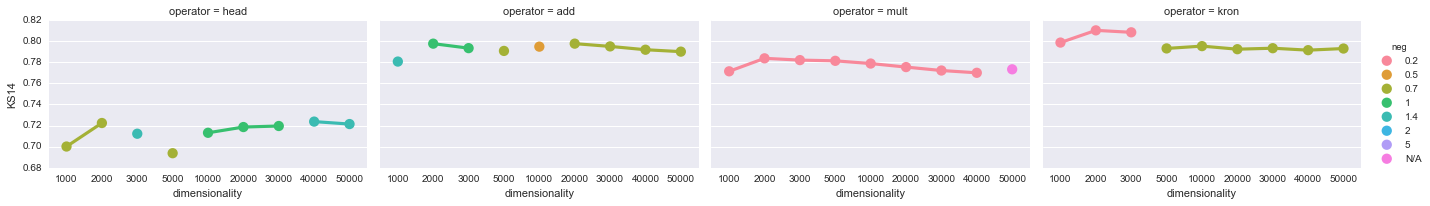

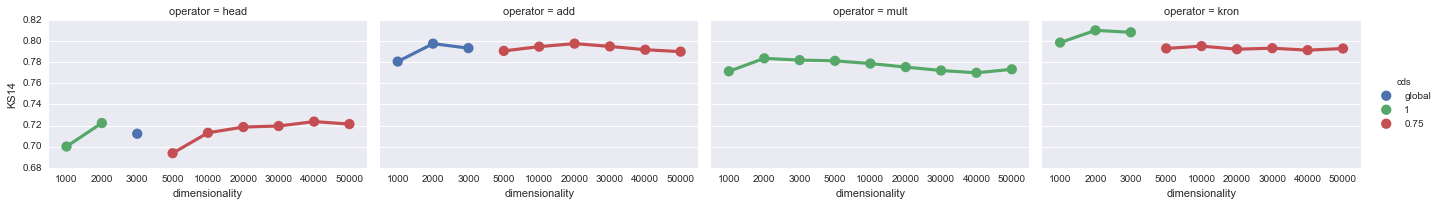

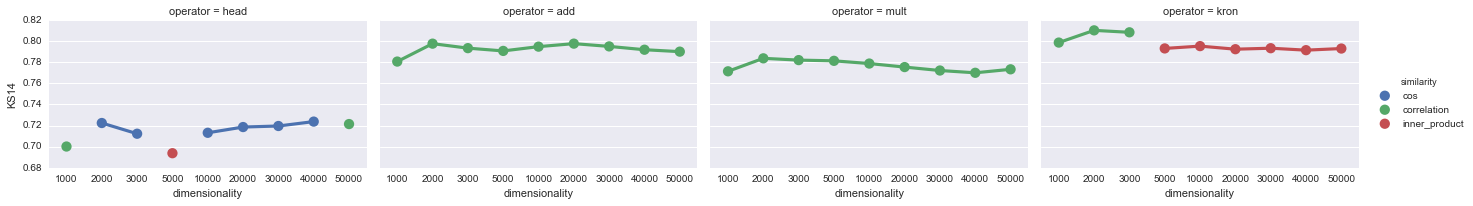

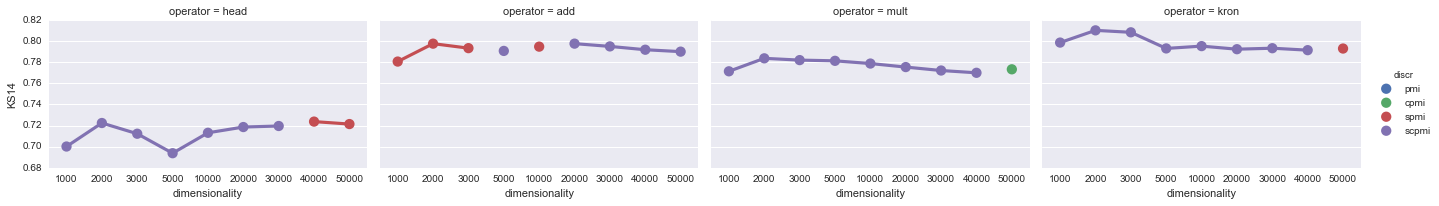

In [111]:
cross_validation_selection_ks14 = t.plot_selection(
    results[results['max', 'KS14'].notnull()],
    dataset='KS14',
    selector_function=t.cross_validation('GS11'),
)

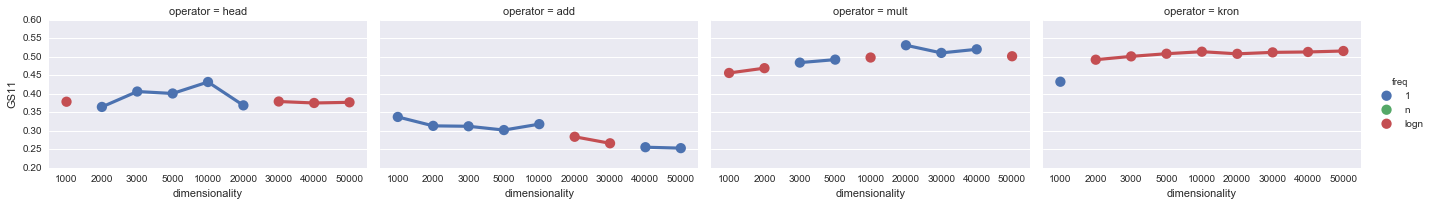

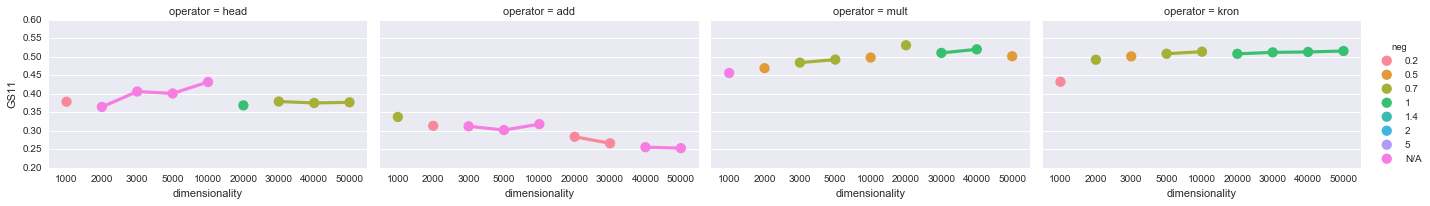

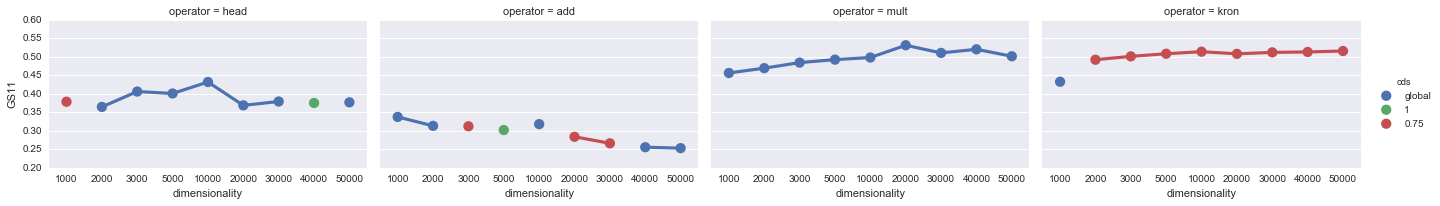

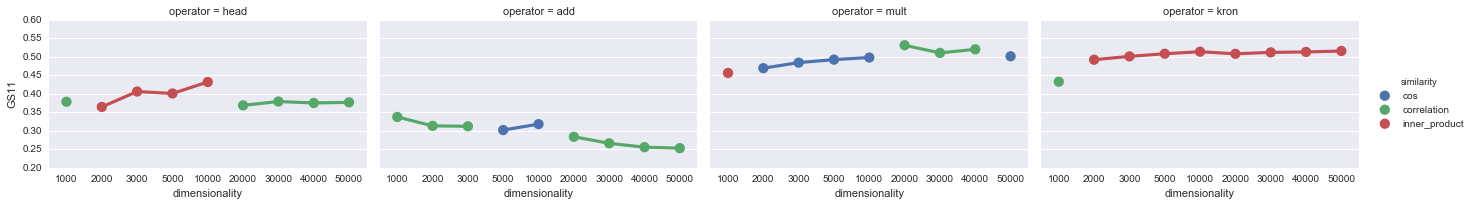

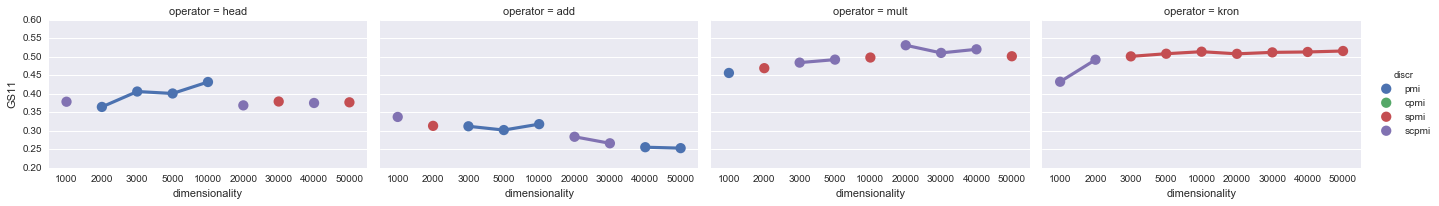

In [110]:
cross_validation_selection_gs11= t.plot_selection(
    results[results['max', 'GS11'].notnull()],
    dataset='GS11',
    selector_function=t.cross_validation('KS14'),
)

## Heuristics 

In [112]:
compositional_parameters = parameters + ['operator']

In [114]:
'{:.3f}'.format(
        t.anova(
        response='KS14',
        predictors=compositional_parameters,
        data=results,
    ).rsquared_adj
)

'0.794'

In [115]:
'{:.3f}'.format(
    t.anova(
        response='GS11',
        predictors=compositional_parameters,
        data=results,
    ).rsquared_adj
)

'0.753'

In [116]:
feature_ablation_ks14 = t.calculate_feature_ablation(
    responses=(
        'KS14',
    ),
    predictors=compositional_parameters,
    data=results,
)

# feature_ablation.plot(kind='barh')#.get_figure().savefig('figures/emnlp2013_turk-parameter-ablation.pdf')
feature_ablation_ks14.sort_values(('partial R2', 'KS14'), ascending=False, inplace=True)

feature_ablation_ks14.round(3)

,partial R2
response,KS14
predictor,
neg,0.331
freq,0.307
operator,0.305
cds,0.136
similarity,0.061
discr,0.054
dimensionality,0.034


## KS14

In [117]:
heuristics_selection_collection_ks14 = {}

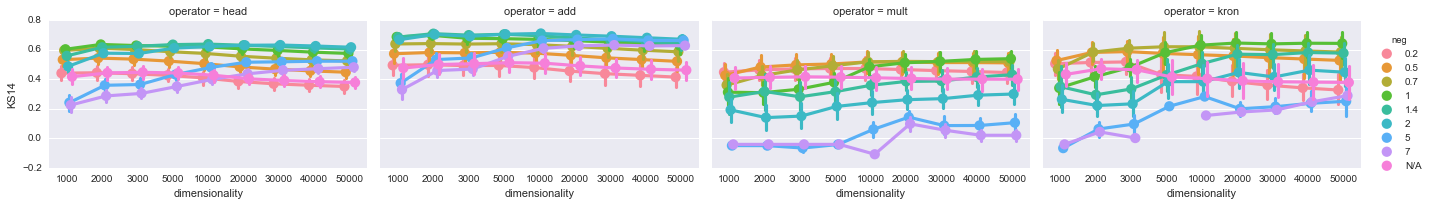

In [119]:
t.plot_interaction(results['max'], feature_ablation_ks14.index[0], 'KS14')

In [120]:
assert feature_ablation_ks14.index[0] == 'neg'

r = results['max'].reset_index()

heuristics_selection_collection_ks14[0] =  r.loc[
    (~((r['operator'] == 'head') & (r['dimensionality'] < 5000)) | ((r['neg'] == 1))) &
    (~((r['operator'] == 'head') & (r['dimensionality'] >= 5000) & (r['dimensionality'] < 30000)) | ((r['neg'] == 1.4))) &
    (~((r['operator'] == 'head') & (r['dimensionality'] >= 30000)) | ((r['neg'] == 2))) &

    (~((r['operator'] == 'add') & (r['dimensionality'] < 20000)) | ((r['neg'] == 1.4))) &
    (~((r['operator'] == 'add') & (r['dimensionality'] >= 20000)) | ((r['neg'] == 2))) &

    (~((r['operator'] == 'mult') & (r['dimensionality'] < 10000)) | ((r['neg'] == 0.5))) &
    (~((r['operator'] == 'mult') & (r['dimensionality'] >= 10000) & (r['dimensionality'] < 30000)) | ((r['neg'] == 0.7))) &
    (~((r['operator'] == 'mult') & (r['dimensionality'] >= 30000)) | ((r['neg'] == 1))) &

    (~((r['operator'] == 'kron') & (r['dimensionality'] < 3000)) | ((r['neg'] == 0.5))) &
    (~((r['operator'] == 'kron') & (r['dimensionality'] >= 3000) & (r['dimensionality'] < 20000)) | ((r['neg'] == 0.7))) &
    (~((r['operator'] == 'kron') & (r['dimensionality'] >= 20000)) | ((r['neg'] == 1))) &

    True
]

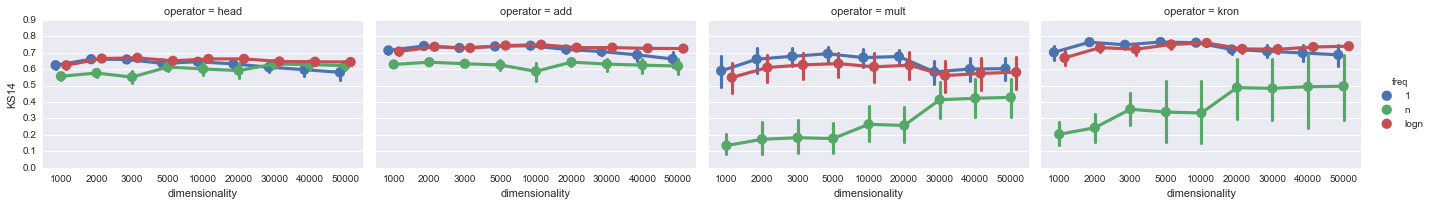

In [121]:
t.plot_interaction(heuristics_selection_collection_ks14[0], feature_ablation_ks14.index[1], 'KS14')

In [122]:
assert feature_ablation_ks14.index[1] == 'freq'

r = heuristics_selection_collection_ks14[0]

heuristics_selection_collection_ks14[1] =  r.loc[
    (~((r['operator'] == 'head')) | (r['freq'] == 'logn')) &

    (~((r['operator'] == 'add') & (r['dimensionality'] < 5000)) | ((r['freq'] == '1'))) &
    (~((r['operator'] == 'add') & (r['dimensionality'] >= 5000)) | ((r['freq'] == 'logn'))) &

    (~((r['operator'] == 'mult')) | (r['freq'] == '1')) &

    (~((r['operator'] == 'kron') & (r['dimensionality'] < 10000)) | ((r['freq'] == '1'))) &
    (~((r['operator'] == 'kron') & (r['dimensionality'] >= 10000)) | ((r['freq'] == 'logn'))) &

    True
]

# t.plot_interaction(heuristics_selection_collection_ks14[1], feature_ablation_ks14.index[1], 'KS14')

In [123]:
assert feature_ablation_ks14.index[2] == 'operator'

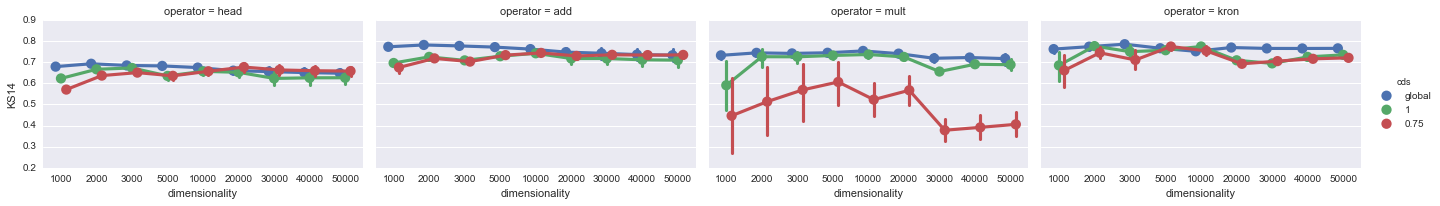

In [124]:
t.plot_interaction(heuristics_selection_collection_ks14[1], feature_ablation_ks14.index[3], 'KS14')

In [125]:
assert feature_ablation_ks14.index[3] == 'cds'

r = heuristics_selection_collection_ks14[1]

heuristics_selection_collection_ks14[2] =  r.loc[
    (~((r['operator'] == 'head') & (r['dimensionality'] < 20000)) | ((r['cds'] == 'global'))) &
    (~((r['operator'] == 'head') & (r['dimensionality'] >= 20000)) | ((r['cds'] == '0.75'))) &

    (~((r['operator'] == 'add')) | (r['cds'] == 'global')) &
    (~((r['operator'] == 'mult')) | (r['cds'] == 'global')) &
    (~((r['operator'] == 'kron')) | (r['cds'] == 'global')) &

    True
]

# t.plot_interaction(heuristics_selection_collection_ks14[1], feature_ablation_ks14.index[1], 'KS14')

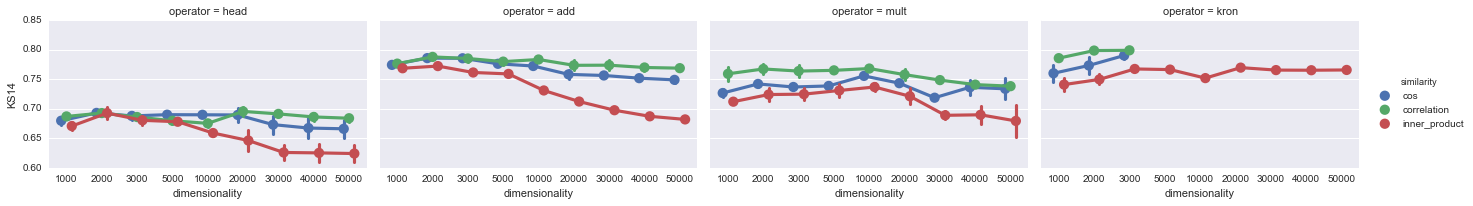

In [126]:
t.plot_interaction(heuristics_selection_collection_ks14[2], feature_ablation_ks14.index[4], 'KS14')

In [127]:
assert feature_ablation_ks14.index[4] == 'similarity'

r = heuristics_selection_collection_ks14[2]

heuristics_selection_collection_ks14[3] =  r.loc[
    (~((r['operator'] == 'head') &  (r['dimensionality'] < 20000)) | (r['similarity'] == 'cos')) &
    (~((r['operator'] == 'head') &  (r['dimensionality'] >= 20000)) | (r['similarity'] == 'correlation')) &

    (~((r['operator'] == 'add')) | (r['similarity'] == 'correlation')) &

    (~((r['operator'] == 'mult')) | (r['similarity'] == 'correlation')) &

    (~((r['operator'] == 'kron') &  (r['dimensionality'] < 5000)) | (r['similarity'] == 'correlation')) &
    (~((r['operator'] == 'kron') &  (r['dimensionality'] >= 5000)) | (r['similarity'] == 'inner_product')) &

    True
]

# t.plot_interaction(heuristics_selection_collection_ks14[3], feature_ablation_ks14.index[4], 'KS14')

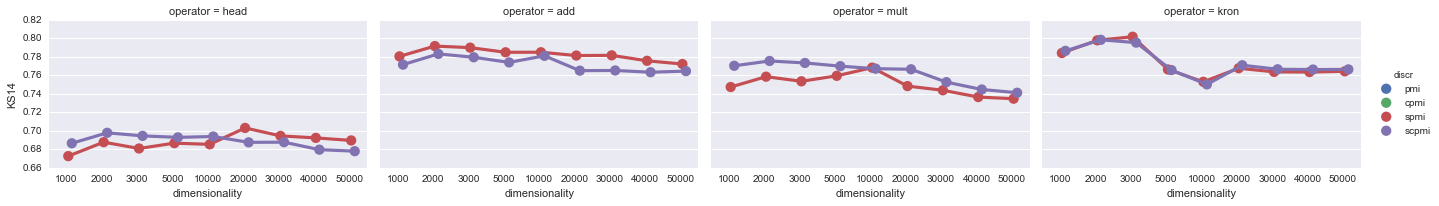

In [128]:
t.plot_interaction(heuristics_selection_collection_ks14[3], feature_ablation_ks14.index[5], 'KS14')

In [129]:
assert feature_ablation_ks14.index[5] == 'discr'

r = heuristics_selection_collection_ks14[3]

heuristics_selection_collection_ks14[4] =  r.loc[
    (~((r['operator'] == 'head') & (r['dimensionality'] < 20000)) | (r['discr'] == 'scpmi')) &
    (~((r['operator'] == 'head') & (r['dimensionality'] >= 20000)) | (r['discr'] == 'spmi')) &

    (~((r['operator'] == 'add')) | (r['discr'] == 'spmi')) &

    (~((r['operator'] == 'mult')) | (r['discr'] == 'scpmi')) &

    (~((r['operator'] == 'mult')) | (r['discr'] == 'scpmi')) &


    (~((r['operator'] == 'kron') & (r['dimensionality'] < 20000)) | (r['discr'] == 'spmi')) &
    (~((r['operator'] == 'kron') & (r['dimensionality'] >= 20000)) | (r['discr'] == 'scpmi')) &

    True
]

# t.plot_interaction(heuristics_selection_collection_ks14[4], feature_ablation_ks14.index[5], 'KS14')

In [130]:
assert feature_ablation_ks14.index[6] == 'dimensionality'

In [131]:
assert len(feature_ablation_ks14) == 7

In [132]:
heuristics_selection_ks14 = heuristics_selection_collection_ks14[4].set_index(['operator', 'dimensionality'], drop=False)
heuristics_selection_ks14['selection'] = 'heuristics'

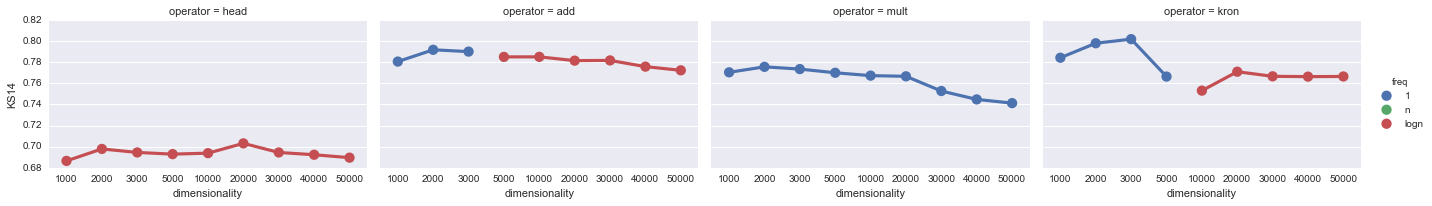

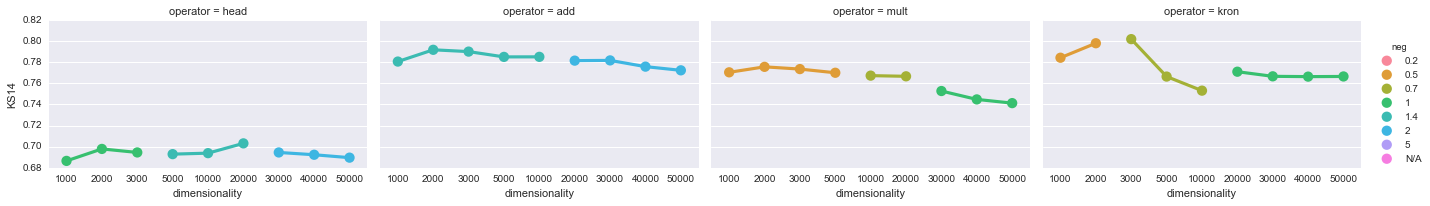

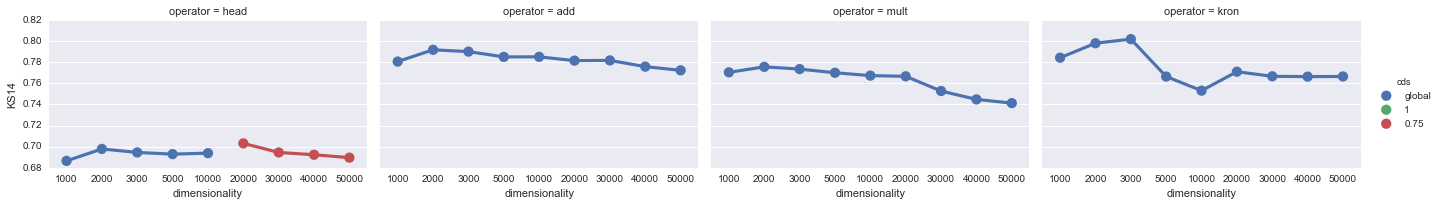

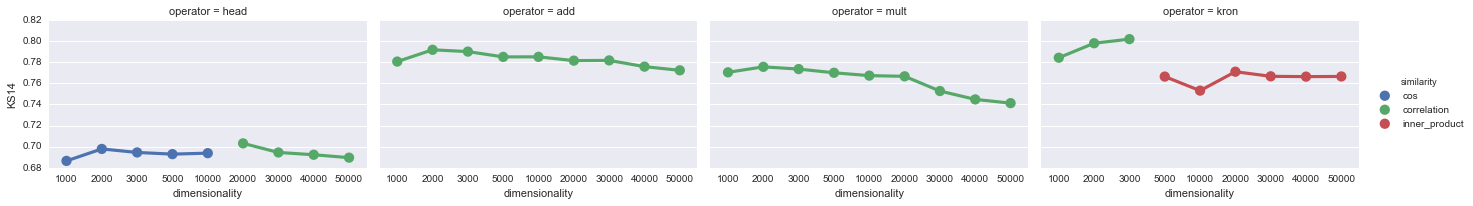

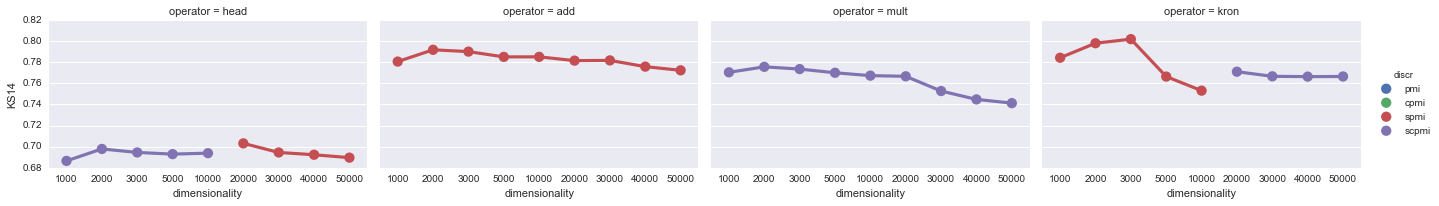

In [133]:
t.plot_selection(
    heuristics_selection_ks14,
    dataset='KS14',
    selector_function='heuristics',
)

## GS11

In [134]:
feature_ablation_gs11 = t.calculate_feature_ablation(
    responses=(
        'GS11',
    ),
    predictors=compositional_parameters,
    data=results,
)

# feature_ablation.plot(kind='barh')#.get_figure().savefig('figures/emnlp2013_turk-parameter-ablation.pdf')
feature_ablation_gs11.sort_values(('partial R2', 'GS11'), ascending=False, inplace=True)

feature_ablation_gs11.round(3)

,partial R2
response,GS11
predictor,
operator,0.367
freq,0.213
neg,0.179
similarity,0.088
cds,0.054
discr,0.039
dimensionality,0.039


In [ ]:
heuristics_selection_collection_gs11 = {}

In [ ]:
assert feature_ablation_gs11.index[0] == 'operator'

In [ ]:
t.plot_interaction(results['max'], feature_ablation_gs11.index[1], 'GS11')

In [ ]:
assert feature_ablation_gs11.index[1] == 'freq'

r = results['max'].reset_index()

heuristics_selection_collection_gs11[0] =  r.loc[
    (r['freq'] == 'logn')
]

In [ ]:
t.plot_interaction(heuristics_selection_collection_gs11[0], feature_ablation_gs11.index[2], 'GS11')

In [ ]:
assert feature_ablation_gs11.index[2] == 'neg'

r = heuristics_selection_collection_gs11[0]

heuristics_selection_collection_gs11[1] =  r.loc[
    (~((r['operator'] == 'head') & (r['dimensionality'] < 3000)) | ((r['neg'] == 0.5))) &
    (~((r['operator'] == 'head') & (r['dimensionality'] >= 3000)) | ((r['neg'] == 0.7))) &

    (~((r['operator'] == 'add') & (r['dimensionality'] < 20000)) | ((r['neg'] == 'N/A'))) &
    (~((r['operator'] == 'add') & (r['dimensionality'] >= 20000)) | ((r['neg'] == 0.2))) &

    (~((r['operator'] == 'mult') & (r['dimensionality'] < 5000)) | ((r['neg'] == 'N/A'))) &
    (~((r['operator'] == 'mult') & (r['dimensionality'] >= 5000)) | ((r['neg'] == 0.7))) &

    (~((r['operator'] == 'kron') & (r['dimensionality'] < 20000)) | ((r['neg'] == 0.7))) &
    (~((r['operator'] == 'kron') & (r['dimensionality'] >= 20000)) | ((r['neg'] == 1))) &

    True
]

# t.plot_interaction(heuristics_selection_collection_gs11[1], feature_ablation_gs11.index[2], 'GS11')

In [ ]:
t.plot_interaction(heuristics_selection_collection_gs11[1], feature_ablation_gs11.index[3], 'GS11')

In [ ]:
assert feature_ablation_gs11.index[3] == 'similarity'

r = heuristics_selection_collection_gs11[1]

heuristics_selection_collection_gs11[2] =  r.loc[
    (~((r['operator'] == 'head')) | ((r['similarity'] == 'cos'))) &
    (~((r['operator'] == 'add')) | ((r['similarity'] == 'correlation'))) &
    (~((r['operator'] == 'mult')) | ((r['similarity'] == 'cos'))) &
    (~((r['operator'] == 'kron')) | ((r['similarity'] == 'inner_product'))) &

    True
]

# t.plot_interaction(heuristics_selection_collection_gs11[2], feature_ablation_gs11.index[3], 'GS11')

In [ ]:
t.plot_interaction(heuristics_selection_collection_gs11[2], feature_ablation_gs11.index[4], 'GS11')

In [ ]:
assert feature_ablation_gs11.index[4] == 'cds'

r = heuristics_selection_collection_gs11[2]

heuristics_selection_collection_gs11[3] =  r.loc[
    (~((r['operator'] == 'head') & (r['dimensionality'] < 10000)) | ((r['cds'] == 'global'))) &
    (~((r['operator'] == 'head') & (r['dimensionality'] >= 10000)) | ((r['cds'] == '1'))) &

    (~((r['operator'] == 'add') & (r['dimensionality'] < 20000)) | ((r['cds'] == '1'))) &
    (~((r['operator'] == 'add') & (r['dimensionality'] >= 20000)) | ((r['cds'] == '0.75'))) &

    (~((r['operator'] == 'mult')) | ((r['cds'] == 'global'))) &

    (~((r['operator'] == 'kron')) | ((r['cds'] == '0.75'))) &

    True
]

# t.plot_interaction(heuristics_selection_collection_gs11[3], feature_ablation_gs11.index[4], 'GS11')

In [ ]:
t.plot_interaction(heuristics_selection_collection_gs11[3], feature_ablation_gs11.index[5], 'GS11')

In [ ]:
assert feature_ablation_gs11.index[5] == 'discr'

r = heuristics_selection_collection_gs11[3]

heuristics_selection_collection_gs11[4] =  r.loc[
    (~((r['operator'] == 'head')) | ((r['discr'] == 'spmi'))) &

    (~((r['operator'] == 'add') & (r['dimensionality'] < 20000)) | ((r['discr'] == 'pmi'))) &
    (~((r['operator'] == 'add') & (r['dimensionality'] >= 20000)) | ((r['discr'] == 'scpmi'))) &

    (~((r['operator'] == 'mult') & (r['dimensionality'] < 5000)) | ((r['discr'] == 'pmi'))) &
    (~((r['operator'] == 'mult') & (r['dimensionality'] >= 5000)) | ((r['discr'] == 'scpmi'))) &

    (~((r['operator'] == 'kron') & (r['dimensionality'] < 5000)) | ((r['discr'] == 'scpmi'))) &
    (~((r['operator'] == 'kron') & (r['dimensionality'] >= 5000)) | ((r['discr'] == 'spmi'))) &

    True
]

# t.plot_interaction(heuristics_selection_collection_gs11[4], feature_ablation_gs11.index[5], 'GS11')

In [ ]:
assert feature_ablation_gs11.index[6] == 'dimensionality'

In [ ]:
assert len(feature_ablation_gs11) == 7

In [ ]:
heuristics_selection_gs11 = heuristics_selection_collection_gs11[4].set_index(['operator', 'dimensionality'], drop=False)
heuristics_selection_gs11['selection'] = 'heuristics'

In [ ]:
t.plot_selection(
    heuristics_selection_gs11,
    dataset='GS11',
    selector_function='heuristics',
)

## Compositional comparison 

In [ ]:
f, axarr = plt.subplots(2, 4, sharex=True, sharey='row', figsize=(15 * 2, 7))

for n, operator in enumerate(('head', 'add', 'mult', 'kron')):
    t.plot_parameter_selection_comparison(
        [
            max_selection_ks14,
            cross_validation_selection_ks14,
            heuristics_selection_ks14,
        ],
        'KS14',
        ax=axarr[0, n],
        operator=operator,
    )

    t.plot_parameter_selection_comparison(
        [
            max_selection_ks14,
            cross_validation_selection_ks14,
            heuristics_selection_ks14,

            max_selection_gs11.assign(selection='upper bound')
        ],
        'KS14',
        'GS11',
        ax=axarr[1, n],
        operator=operator,
    )

In [ ]:
f, axarr = plt.subplots(2, 4, sharex=True, sharey=False, figsize=(15 * 2, 7))

for n, operator in enumerate(('head', 'add', 'mult', 'kron')):
    t.plot_parameter_selection_comparison(
        [
            max_selection_gs11,
            cross_validation_selection_gs11,
            heuristics_selection_gs11,
        ],
        'GS11',
        ax=axarr[0, n],
        operator=operator,
    )

    t.plot_parameter_selection_comparison(
        [
            max_selection_gs11,
            cross_validation_selection_gs11,
            heuristics_selection_gs11,

            max_selection_ks14.assign(selection='upper bound')
        ],
        'GS11',
        other_dataset='KS14',
        ax=axarr[1, n],
        operator=operator,
    )

In [ ]:
# f, axs = plt.subplots(1, 4, figsize=(14, 3), sharey=True)

t.plot_parameter_selection_comparison(
    [
        max_selection_ks14,
        cross_validation_selection_ks14,
        heuristics_selection_ks14,
    ],
    'KS14',
#     ax=ax,
    col='operator',
).fig.savefig('figures/ks14-results.pdf')
    
# # f.savefig('figures/men-results.pdf')

# f, ax = plt.subplots(figsize=(7, 3))
# t.plot_parameter_selection_comparison(
#     [
#         max_selection_men,
#         cross_validation_selection_men,
#         heuristics_selection_men,

#         max_selection_simlex.assign(selection='upper bound')
#     ],
#     'men',
#     'SimLex999',
#     ax=ax,
# )
# f.savefig('figures/men-transfer.pdf')

In [ ]:
max_selection_ks14.loc[
    ['head', 'add', 'mult', 'kron',]
].sort_index().round({'KS14': 3}).to_latex(
    'figures/ks14-max-selection.tex',
    columns=[
        'KS14',
        'freq',
        'discr',
        'cds',
        'neg',
        'similarity',
    ],
)